In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Download data

In [9]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
trainset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./CIFAR', train=False, transform=transform)

Files already downloaded and verified


In [11]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32, shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

# Inception Neural Network

In [12]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

# Obtain the current device

In [13]:
print(torch.cuda.is_available())
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

False


device(type='cpu')

# Gaussian Noise

In [14]:
def get_gaussian_image(batch, w, h):
    # CIFAR 10 mean and std in RGB format. Source: https://github.com/facebookarchive/fb.resnet.torch/issues/180
    mean = [125.3, 123.0, 113.9]
    std = [63.0, 62.1, 66.7]
    out = list()
    for i in range(batch):
        r_channel = torch.normal(mean[0], std[0], size=(w, h)).unsqueeze(0)
        g_channel = torch.normal(mean[1], std[1], size=(w, h)).unsqueeze(0)
        b_channel = torch.normal(mean[2], std[2], size=(w, h)).unsqueeze(0)
        out.append(torch.cat((r_channel, g_channel, b_channel), dim=0).unsqueeze(0))
    return torch.cat(out, dim=0)

# Function to run the randomization test

In [15]:

def training_loop(model, num_epochs, train_loader, valid_loader, device, 
                  criterion, optimizer, scheduler, model_name, 
                  random_shuffle=False, shuffled_pixels=False, 
                  random_pixels=False, gaussian_noise=False):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    rng = None
    if random_pixels:
        rng = np.random.default_rng()
        
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(
            train_loader, model, device, criterion, optimizer, 
            random_shuffle, shuffled_pixels, random_pixels, gaussian_noise, rng)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {:.4f} Validation Loss: {:.4f} Train Acc: {:.4f} Validation Acc: {:.4f}".format(
              epoch + 1, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
        
        scheduler.step()
        
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs

def run_train_single_epoch(train_loader, model, device, criterion, optimizer, 
                           random_shuffle, shuffled_pixels, random_pixels, gaussian_noise, rng):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        if random_shuffle:
            torch.manual_seed(0)
            labels = labels[torch.randperm(len(labels))]
        if shuffled_pixels:
            data_ = inputs.cpu().numpy()
            rng = np.random.default_rng(26)
            data_perm = rng.permutation(data_, axis=2)
            inputs = torch.from_numpy(data_perm).to(device)
        if random_pixels:
            data_ = inputs.cpu().numpy()
            data_perm = rng.permutation(data_, axis=2)
            inputs = torch.from_numpy(data_perm).to(device)
        if gaussian_noise:
            batch = inputs.shape[0]
            w = inputs.shape[-1]
            h = inputs.shape[-2]
            inputs = get_gaussian_image(batch, w, h).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(inputs)
        if batch_num % 200 == 0:
            print("Batch {} Loss: {:.4f}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.sampler)
    epoch_acc = num_correct / len(train_loader.sampler)
    return epoch_loss, epoch_acc

def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(valid_loader.sampler)
    epoch_acc = num_correct / len(valid_loader.sampler)
    return epoch_loss, epoch_acc


# Function to plot the results

In [16]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

Declare a dictionary where is the probability of each class be changed, for example, if we want to change the probability of the class 0 be changed we can use the following dictionary:s

In [17]:
final_dict = dict()

# Test Shuffle Pixels

In [18]:
model = InceptionNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
criterion = nn.CrossEntropyLoss()
train_losses, valid_losses, train_accs, valid_accs = training_loop(train_loader=trainloader, valid_loader=testloader, model=model, device=device, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=100, model_name='Shuffled_pixels', shuffled_pixels=True)

Batch 0 Loss: 2.2631
Batch 200 Loss: 2.3173
Batch 400 Loss: 2.3181
Batch 600 Loss: 2.2843
Batch 800 Loss: 2.3081
Batch 1000 Loss: 2.3180
Batch 1200 Loss: 2.3582
Batch 1400 Loss: 2.3041
[Epoch 1] Train Loss: 2.5360 Validation Loss: 2.3850 Train Acc: 0.1056 Validation Acc: 0.1009
Batch 0 Loss: 2.3708
Batch 200 Loss: 2.3146
Batch 400 Loss: 2.2959
Batch 600 Loss: 2.2578
Batch 800 Loss: 2.3159
Batch 1000 Loss: 2.1845
Batch 1200 Loss: 1.9844
Batch 1400 Loss: 2.0712
[Epoch 2] Train Loss: 2.2233 Validation Loss: 2.5177 Train Acc: 0.1434 Validation Acc: 0.1588
Batch 0 Loss: 2.0725
Batch 200 Loss: 2.0911
Batch 400 Loss: 1.8821
Batch 600 Loss: 1.9173
Batch 800 Loss: 1.7699
Batch 1000 Loss: 2.0680
Batch 1200 Loss: 1.6538
Batch 1400 Loss: 1.6467
[Epoch 3] Train Loss: 1.9440 Validation Loss: 2.2889 Train Acc: 0.2643 Validation Acc: 0.2320
Batch 0 Loss: 1.6196
Batch 200 Loss: 1.8292
Batch 400 Loss: 2.0213
Batch 600 Loss: 1.7486
Batch 800 Loss: 1.5537
Batch 1000 Loss: 1.8471
Batch 1200 Loss: 1.8505
Ba

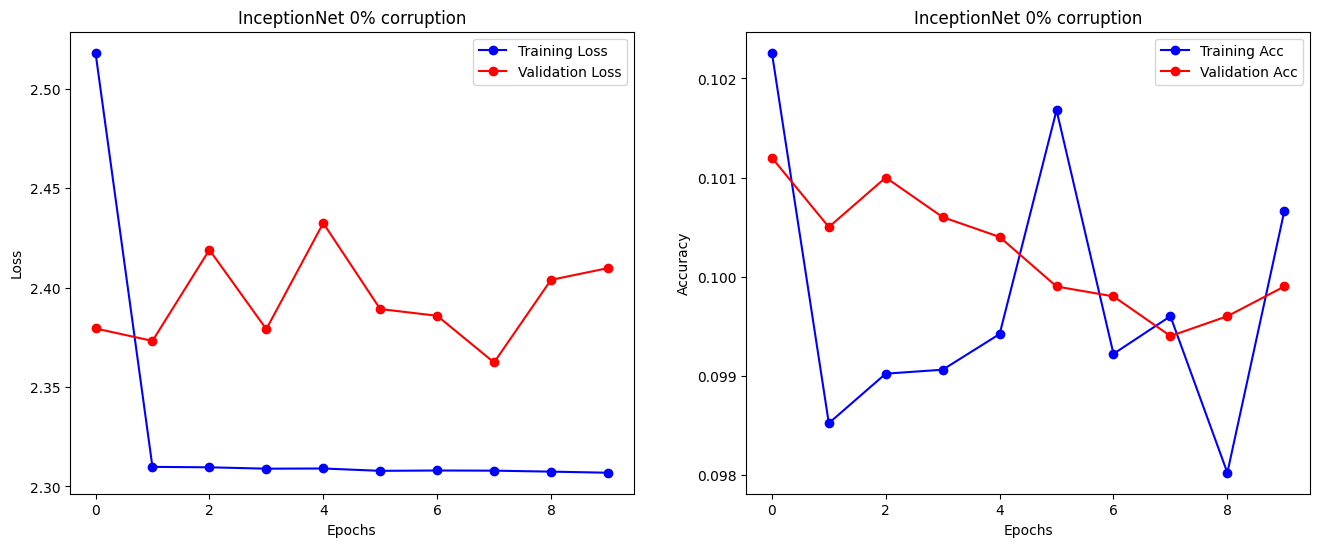

In [ ]:
plot_losses(train_losses, valid_losses,train_accs, valid_accs, "InceptionNet Shuffled Pixels")

In [ ]:
final_dict['shuffled_pixels']={}
final_dict['shuffled_pixels']['train_losses'] = train_losses
final_dict['shuffled_pixels']['valid_losses'] = valid_losses
final_dict['shuffled_pixels']['train_accs'] = train_accs
final_dict['shuffled_pixels']['valid_accs'] = valid_accs

# Test Random Pixels

In [ ]:
model = InceptionNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
criterion = nn.CrossEntropyLoss()
train_losses, valid_losses, train_accs, valid_accs = training_loop(train_loader=trainloader, valid_loader=testloader, model=model, device=device, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=100, model_name='Random_pixels', random_pixels=True)

In [ ]:
plot_losses(train_losses, valid_losses,train_accs, valid_accs, "InceptionNet Random Pixels")

In [ ]:
final_dict['random_pixels']={}
final_dict['random_pixels']['train_losses'] = train_losses
final_dict['random_pixels']['valid_losses'] = valid_losses
final_dict['random_pixels']['train_accs'] = train_accs
final_dict['random_pixels']['valid_accs'] = valid_accs

# Test Gaussian Noise

In [ ]:
model = InceptionNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
criterion = nn.CrossEntropyLoss()
train_losses, valid_losses, train_accs, valid_accs = training_loop(train_loader=trainloader, valid_loader=testloader, model=model, device=device, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=100, model_name='Gaussian_noise', random_pixels=True)

In [ ]:
plot_losses(train_losses, valid_losses,train_accs, valid_accs, "InceptionNet Gaussian Noise")

In [ ]:
final_dict['gaussian_noise']={}
final_dict['gaussian_noise']['train_losses'] = train_losses
final_dict['gaussian_noise']['valid_losses'] = valid_losses
final_dict['gaussian_noise']['train_accs'] = train_accs
final_dict['gaussian_noise']['valid_accs'] = valid_accs

# Save the results

In [ ]:
with open('final_input.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)